In [1]:
# -----------------------------------
# PREPARAR OS DADOS PARA O MODELO GAN
# -----------------------------------

import json
import cv2
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt

DIRECTORY = "new_dataset/masks_256"
json_file = "dataset_contours_aggregate.json"

# Pasta para salvar máscaras binárias
os.makedirs(DIRECTORY, exist_ok=True)

# Função para desenhar contornos em uma máscara
def draw_mask_from_contours(contours, size=256):
    mask = np.zeros((size, size), dtype=np.uint8)
    for c in contours.values():
        x = np.array(c["x"], np.float32)
        y = np.array(c["y"], np.float32)
        pts = np.vstack((x, y)).T.astype(np.int32)
        pts = pts.reshape((-1, 1, 2))
        cv2.drawContours(mask, [pts], -1, 255, -1)
    return mask

# Carregar contornos e gerar máscaras
with open(json_file, "r") as f:
    contours_data = json.load(f)

for image_name, contours in contours_data.items():
    mask = draw_mask_from_contours(contours, size=256)
    cv2.imwrite(f"{DIRECTORY}/{os.path.splitext(image_name)[0]}_mask.png", mask)

print(f"Máscaras binárias salvas em {DIRECTORY}")

Máscaras binárias salvas em new_dataset/masks_256


In [2]:
# --------------------------
# DATASET PYTORCH
# --------------------------

class MaskDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".png")]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("L")
        if self.transform:
            img = self.transform(img)
        return img

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),  # Normaliza para [0, 1]
])

dataset = MaskDataset(DIRECTORY, transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [3]:
# --------------------------
# DEFINIR A DCGAN
# --------------------------

# Gerador
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()  # Agora saída [0, 1]
        )

    def forward(self, x):
        return self.main(x)

# Discriminador
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [4]:
# --------------------------
# TREINAMENTO DA GAN
# --------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 50
latent_dim = 100

os.makedirs("generated_masks", exist_ok=True)

for epoch in range(num_epochs):
    for i, real_imgs in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # ----- Treina o Discriminador -----
        D.zero_grad()

        outputs_real = D(real_imgs)
        loss_real = criterion(outputs_real, torch.ones_like(outputs_real))

        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = G(z)
        outputs_fake = D(fake_imgs.detach())
        loss_fake = criterion(outputs_fake, torch.zeros_like(outputs_fake))

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizerD.step()

        # ----- Treina o Gerador -----
        G.zero_grad()
        outputs = D(fake_imgs)
        loss_G = criterion(outputs, torch.ones_like(outputs))
        loss_G.backward()
        optimizerG.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss_D: {loss_D:.4f}, Loss_G: {loss_G:.4f}")

    # Salvar exemplos de máscaras geradas a cada 5 épocas
    if (epoch + 1) % 5 == 0:
        G.eval()
        with torch.no_grad():
            z = torch.randn(1, latent_dim, 1, 1, device=device)
            fake_img = G(z).cpu().squeeze().numpy()
            fake_img = (fake_img > 0.5).astype(np.uint8) * 255  # Binariza
            cv2.imwrite(f"generated_masks/fake_epoch_{epoch+1}.png", fake_img)
        G.train()

Epoch [1/50] Loss_D: 0.7899, Loss_G: 5.2442
Epoch [2/50] Loss_D: 0.6166, Loss_G: 4.7731
Epoch [3/50] Loss_D: 0.5095, Loss_G: 5.0584
Epoch [4/50] Loss_D: 0.3141, Loss_G: 5.3125
Epoch [5/50] Loss_D: 0.1892, Loss_G: 4.9702
Epoch [6/50] Loss_D: 0.2222, Loss_G: 5.1655
Epoch [7/50] Loss_D: 0.1772, Loss_G: 5.1837
Epoch [8/50] Loss_D: 0.2826, Loss_G: 5.2307
Epoch [9/50] Loss_D: 0.2005, Loss_G: 5.3652
Epoch [10/50] Loss_D: 0.2350, Loss_G: 5.5157
Epoch [11/50] Loss_D: 0.0921, Loss_G: 5.3176
Epoch [12/50] Loss_D: 0.0639, Loss_G: 5.2365
Epoch [13/50] Loss_D: 0.1627, Loss_G: 5.5490
Epoch [14/50] Loss_D: 0.0544, Loss_G: 6.0438
Epoch [15/50] Loss_D: 0.1005, Loss_G: 5.7048
Epoch [16/50] Loss_D: 0.1395, Loss_G: 5.5194
Epoch [17/50] Loss_D: 0.0785, Loss_G: 5.6269
Epoch [18/50] Loss_D: 0.1688, Loss_G: 5.7816
Epoch [19/50] Loss_D: 0.0311, Loss_G: 5.5807
Epoch [20/50] Loss_D: 0.1798, Loss_G: 5.4619
Epoch [21/50] Loss_D: 0.0294, Loss_G: 5.5699
Epoch [22/50] Loss_D: 0.1048, Loss_G: 5.5181
Epoch [23/50] Loss_

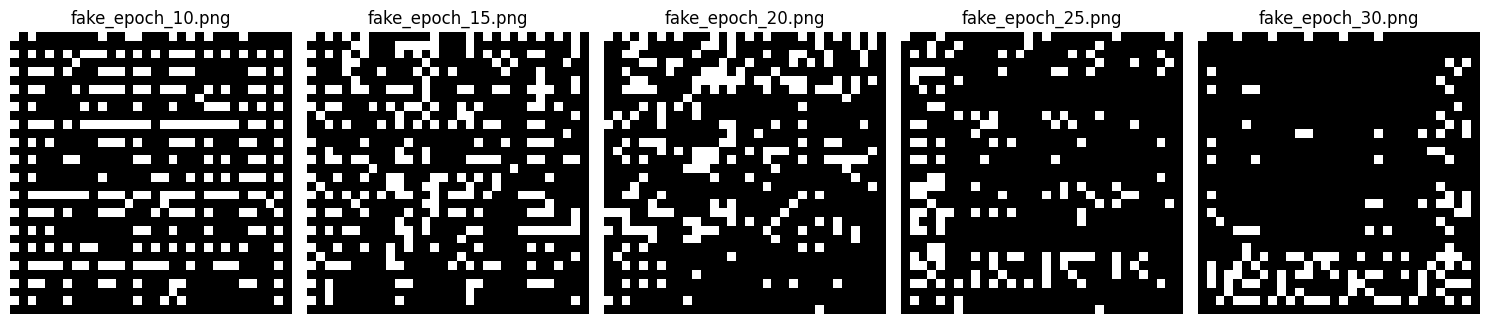

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Pasta onde as máscaras estão salvas
generated_dir = "generated_masks"

# Lista de arquivos gerados
generated_files = sorted([f for f in os.listdir(generated_dir) if f.endswith(".png")])

# Plotar as máscaras
plt.figure(figsize=(15, 5))
for i, file in enumerate(generated_files[:5]):  # Exibir apenas 5 exemplos
    img = cv2.imread(os.path.join(generated_dir, file), cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(file)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
# --------------------------
# CONVERTER AS MÁSCARAS GERADAS PARA CONTORNOS
# --------------------------

new_contours = {}
for file in os.listdir("generated_masks"):
    img = cv2.imread(os.path.join("generated_masks", file), cv2.IMREAD_GRAYSCALE)
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    new_contours[file] = {}
    for i, c in enumerate(contours):
        coords = c[:, 0, :]
        new_contours[file][str(i)] = {
            "x": coords[:, 0].tolist(),
            "y": coords[:, 1].tolist()
        }

with open("generated_contours.json", "w") as f:
    json.dump(new_contours, f, indent=4)

print("Novos contornos salvos em generated_contours.json")

Novos contornos salvos em generated_contours.json
